# This is a file that takes in the master dataset and constructs a predictor

In [73]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import graphviz

In [2]:
df = pd.read_csv('../master_data.csv')
df.head(3)

C:\Users\moyersjm\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3,4,5,12,13,14,15,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,video_id,title,channel_id,channel_title,published_at,view_count,likes,dislikes,comment_count,...,description,comments,publishedAt,channelId,channelTitle,categoryId,trending_date,thumbnail_link,comments_disabled,ratings_disabled
0,0,--0bCF-iK2E,Jadon Sancho Magical Skills & Goals,UC6UL29enLNe4mqwTfAyeNuw,Bundesliga,2021-07-01 10:00:00,1048888,19515,226,1319,...,Enjoy the best skills and goals from Jadon San...,"Respect to Dortmund fans,must be sad losing hi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,--14w5SOEUs,Migos - Avalanche (Official Video),UCGIelM2Dj3zza3xyV3pL3WQ,MigosVEVO,2021-06-10 16:00:00,15352638,359277,7479,18729,...,"Watch the the official video for Migos - ""Aval...",Migos just makes me want to live my live to th...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,--40TEbZ9Is,Supporting Actress in a Comedy: 73rd Emmys,UClBKH8yZRcM4AsRjDVEdjMg,Television Academy,2021-09-20 01:03:32,925281,11212,401,831,...,Hannah Waddingham wins the Emmy for Supporting...,Hannah's energy bursts through any screen. Wel...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.dtypes

Unnamed: 0             int64
video_id              object
title                 object
channel_id            object
channel_title         object
published_at          object
view_count             int64
likes                  int64
dislikes               int64
comment_count          int64
tags                  object
description           object
comments              object
publishedAt           object
channelId             object
channelTitle          object
categoryId           float64
trending_date         object
thumbnail_link        object
comments_disabled     object
ratings_disabled      object
dtype: object

In [4]:
df.channel_id.fillna(df.channelId,inplace=True)
df.channel_title.fillna(df.channelTitle,inplace=True)
df.published_at.fillna(df.publishedAt,inplace=True)

In [5]:
features = df.drop(['Unnamed: 0','video_id',
                    'title','channel_id',
                    #'dislikes',
                    'tags',
                    'description',
                    'comments','publishedAt',
                    'channelId','channelTitle',
                    'categoryId','trending_date',
                   'thumbnail_link','comments_disabled',
                   'ratings_disabled'], axis=1)
features = features.dropna()
target = features.dislikes
features = features.drop('dislikes',axis=1)
features.head(3)

,channel_title,published_at,view_count,likes,comment_count
0,Bundesliga,2021-07-01 10:00:00,1048888,19515,1319
1,MigosVEVO,2021-06-10 16:00:00,15352638,359277,18729
2,Television Academy,2021-09-20 01:03:32,925281,11212,831


In [6]:
features.shape

(1032704, 5)

In [7]:
df.shape

(1032705, 21)

Sidenote: legitimately wasn't expecting to only lose 1 row. I'm pretty happy with that.

In [8]:
features.channel_title = features.channel_title.astype('category')
features.dtypes

channel_title    category
published_at       object
view_count          int64
likes               int64
comment_count       int64
dtype: object

### Warning:
to_datetime takes about 5 minutes to run

In [9]:
# features.published_at = pd.to_datetime(features.published_at)

In [10]:
features['q_comment_count'] = pd.qcut(features.comment_count,q=5,labels=['low','mid-low','mid','mid-high','high'])
features.head(3)

,channel_title,published_at,view_count,likes,comment_count,q_comment_count
0,Bundesliga,2021-07-01 10:00:00,1048888,19515,1319,mid
1,MigosVEVO,2021-06-10 16:00:00,15352638,359277,18729,high
2,Television Academy,2021-09-20 01:03:32,925281,11212,831,mid-low


In [11]:
features['q_likes'] = pd.qcut(features.likes,q=5,labels=['low','mid-low','mid','mid-high','high'])
features['q_view_count'] = pd.qcut(features.view_count,q=5,labels=['low','mid-low','mid','mid-high','high'])
features.head(3)

,channel_title,published_at,view_count,likes,comment_count,q_comment_count,q_likes,q_view_count
0,Bundesliga,2021-07-01 10:00:00,1048888,19515,1319,mid,mid,mid-high
1,MigosVEVO,2021-06-10 16:00:00,15352638,359277,18729,high,high,high
2,Television Academy,2021-09-20 01:03:32,925281,11212,831,mid-low,mid-low,mid-high


In [12]:
binned_feats = features.drop(['view_count','likes','comment_count'],axis=1)
binned_feats.head(3)

,channel_title,published_at,q_comment_count,q_likes,q_view_count
0,Bundesliga,2021-07-01 10:00:00,mid,mid,mid-high
1,MigosVEVO,2021-06-10 16:00:00,high,high,high
2,Television Academy,2021-09-20 01:03:32,mid-low,mid-low,mid-high


In [13]:
# binned_feats.published_at = pd.to_datetime(binned_feats.published_at,utc=True)
# binned_feats.published_at = (binned_feats.published_at + pd.offsets.MonthBegin(0)).dt.date
# binned_feats.published_at = binned_feats.published_at.astype('category')
binned_feats = binned_feats.drop('published_at',axis=1)
binned_feats.head(3)

,channel_title,q_comment_count,q_likes,q_view_count
0,Bundesliga,mid,mid,mid-high
1,MigosVEVO,high,high,high
2,Television Academy,mid-low,mid-low,mid-high


In [14]:
binned_feats = binned_feats.drop(['channel_title'],axis=1)
binned_feats = pd.get_dummies(binned_feats)
binned_feats.head(3)

,q_comment_count_low,q_comment_count_mid-low,q_comment_count_mid,q_comment_count_mid-high,q_comment_count_high,q_likes_low,q_likes_mid-low,q_likes_mid,q_likes_mid-high,q_likes_high,q_view_count_low,q_view_count_mid-low,q_view_count_mid,q_view_count_mid-high,q_view_count_high
0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0


In [15]:
target = pd.qcut(target,q=7,labels=['very-low','low','mid-low','mid','mid-high','high','very-high'])
target

0            mid-low
1          very-high
2                mid
3                mid
4                mid
             ...    
1032700     very-low
1032701     very-low
1032702     very-low
1032703     very-low
1032704     very-low
Name: dislikes, Length: 1032704, dtype: category
Categories (7, object): ['very-low' < 'low' < 'mid-low' < 'mid' < 'mid-high' < 'high' < 'very-high']

In [16]:
NB = MultinomialNB()
NB.fit(binned_feats, target)

MultinomialNB()

In [17]:
(1 - NB.score(binned_feats, target)).round(3)

0.6

That's a pretty staggering error rate. Let's see how trees handle it

In [18]:
# parameters = {'max_depth':range(1,11)}
# Tree = tree.DecisionTreeClassifier()
# TreeCV = GridSearchCV(Tree,
#                      param_grid=parameters,
#                      return_train_score=True,
#                      n_jobs=-1)
# TreeCV.fit(binned_feats,target)

In [19]:
# TreeCV.best_params_

In [20]:
# TreeCV.best_score_

Wow that's also pretty bad.
I would add more meaningful things like channel title but I don't have enough memory to do the full set.
Therefore, I'll try to poll a representative sample from the dataset and use that instead.

In [21]:
binned_feats['channel_title'] = features.channel_title
binned_feats = binned_feats.sample(frac=1/10)
target = target.drop(target.drop(binned_feats.index).index)

In [22]:
binned_feats = pd.get_dummies(binned_feats)

In [23]:
Tree = tree.DecisionTreeClassifier(max_depth=9)
Tree.fit(binned_feats,target)

DecisionTreeClassifier(max_depth=9)

In [41]:
binned_pred_set = binned_feats.sample(frac=1/10)
target_pred = target.drop(target.drop(binned_pred_set.index).index)
binned_pred_set = pd.get_dummies(binned_pred_set)

In [45]:
predictions = Tree.predict(binned_pred_set)

In [47]:
num_records = predictions.shape[0]
(target_pred != predictions).sum() / num_records

0.8548465188341241

In [48]:
randos = df.sample(40)
randos.head(3)

,Unnamed: 0,video_id,title,channel_id,channel_title,published_at,view_count,likes,dislikes,comment_count,...,description,comments,publishedAt,channelId,channelTitle,categoryId,trending_date,thumbnail_link,comments_disabled,ratings_disabled
630465,630465,hNi5YQKxp78,400種類のアレルギー検査を受けたら衝撃的な結果が出てしまいました...,UCfleuaM45FPQOfVK8XSheDA,肉チョモランマ,2021-03-24T10:00:09Z,278251,13399,105,1593,...,どうも肉チョモランマです！毎週日曜、水曜、金曜日の夜19時に動画投稿したりしなかったり。チャ...,NaN,2021-03-24T10:00:09Z,UCfleuaM45FPQOfVK8XSheDA,肉チョモランマ,23.0,2021-03-26T00:00:00Z,https://i.ytimg.com/vi/hNi5YQKxp78/default.jpg,False,False
272020,272020,p9LLoijPQfg,TREASURE - ‘MY TREASURE’ M/V,UCx9hXYOCvUYwrprEqe4ZQHA,TREASURE (트레저),2021-01-11T09:00:11Z,9557386,909844,8099,472102,...,MY TREASURE지친 하늘빛해는 잠들고바람이 불면다 지나가고 있어꿈에서 깬 듯다...,NaN,2021-01-11T09:00:11Z,UCx9hXYOCvUYwrprEqe4ZQHA,TREASURE (트레저),24.0,2021-01-14T00:00:00Z,https://i.ytimg.com/vi/p9LLoijPQfg/default.jpg,False,False
702071,702071,TOwWo3di9do,아이폰 12 간단한 언박싱과 첫인상,UCQ2a9oTOgf1P5y32uiS-whQ,Route 9 루트나인,2020-10-25T13:37:28Z,126755,1584,112,546,...,아이폰12가 드디어 우리곁에 찾아 왔습니다. ㅠㅠ 애플의 첫 5G 아이폰이라서 설레...,NaN,2020-10-25T13:37:28Z,UCQ2a9oTOgf1P5y32uiS-whQ,Route 9 루트나인,28.0,2020-10-30T00:00:00Z,https://i.ytimg.com/vi/TOwWo3di9do/default.jpg,False,False


In [50]:
randos.video_id.to_csv('./random_ids.csv')

In [51]:
random_stats = pd.read_csv('./random_stats.csv')
random_stats.head(3)

,id,dateCreated,likes,dislikes,rating,viewCount,deleted
0,hNi5YQKxp78,2022-01-18T23:59:40.833977Z,19620,137,4.969047,643968.0,False
1,p9LLoijPQfg,2022-01-27T21:25:50.377917Z,1443161,14816,4.958923,39218368.0,False
2,TOwWo3di9do,2022-01-28T05:23:39.3704875Z,1617,97,4.736416,133811.0,False


In [53]:
random_stats = random_stats.dropna()

In [63]:
binned_feats['id'] = df.video_id

In [70]:
random_pred_set = binned_feats[binned_feats.id.isin(random_stats.id)].drop('id',axis=1)

In [71]:
random_pred = Tree.predict(random_pred_set)

In [72]:
results = pd.DataFrame()
results['predicted_dislikes'] = random_pred
results['api_dislikes'] = random_stats.dislikes
results['actual_dislikes'] = df[df.video_id.isin(random_stats.id)].dislikes
results

,predicted_dislikes,api_dislikes,actual_dislikes
0,low,137,NaN
1,low,14816,NaN
2,low,97,NaN
3,low,10142,NaN
4,low,140,NaN
5,low,24,NaN
6,low,7313,NaN
7,low,2417,NaN
8,low,57,NaN
9,low,1414,NaN


In [76]:
dot_data = tree.export_graphviz(Tree,
                               out_file=None,
                               feature_names=binned_feats.drop('id',axis=1).columns,
                               class_names=Tree.classes_,
                               proportion=True, # Gives how many in each classification
                               impurity=False, # GINI index
                               filled=True, # Color based on classification
                               rounded=True)

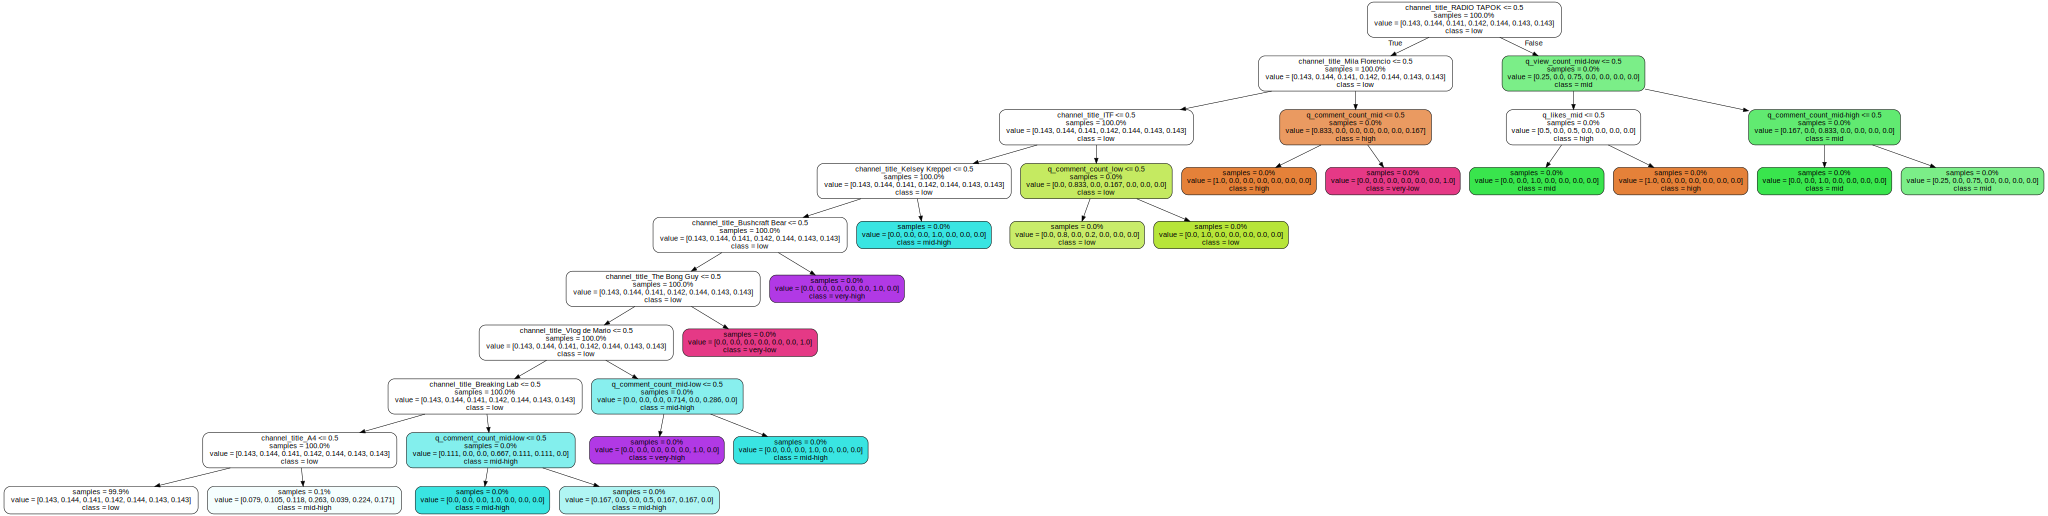

In [77]:
graph = graphviz.Source(dot_data)
graph

In [81]:
target.sample(10)

744387          low
15792     very-high
297721     mid-high
843415     very-low
508642         high
823404    very-high
953384          low
958850          low
230010     very-low
843996          low
Name: dislikes, dtype: category
Categories (7, object): ['very-low' < 'low' < 'mid-low' < 'mid' < 'mid-high' < 'high' < 'very-high']